In [129]:
import pandas as pd

In [130]:
df=pd.read_csv("D:\\DRUG\\Drug_CNN\\Bortezomib_interaction.csv")

In [131]:
atoms={}
i=0
maxm=0
for x in df['smiles']:
    maxm=max(maxm,len(x))
    for j in x:
        if j not in atoms:
            atoms[j]=i
            i+=1

In [132]:
maxm

357

In [133]:
len(atoms)

34

In [6]:
input_data=[]
for x,y in zip(df['smiles'],df['interact']):
    tsr=[[0]*maxm for i in range(len(atoms))]
    k=0
    for j in x:
        tsr[atoms[j]][k]=1
        k+=1
    input_data.append([tsr,y])

In [7]:
import numpy as np
def split_dataset(dataset, ratio):
    """Shuffle and split a dataset."""
    np.random.seed(1234)  # fix the seed for shuffle.
    np.random.shuffle(dataset)
    n = int(ratio * len(dataset))
    return dataset[:n], dataset[n:]

In [8]:
dataset_train, dataset_test=split_dataset(input_data,0.9)

In [9]:
train_gen=np.array([np.array(x[0]).reshape(len(atoms),maxm,1) for x in dataset_train])
train_lab=np.array([x[1] for x in dataset_train])
test_gen=np.array([np.array(x[0]).reshape(len(atoms),maxm,1) for x in dataset_test])
test_lab=np.array([x[1] for x in dataset_test])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es= EarlyStopping(monitor="accuracy",min_delta=0.02,patience=6,verbose=1,mode='auto')
mc=ModelCheckpoint(monitor="accuracy",filepath="D:\\Phase II Project Work\\DRUG\\Drug_CNN\\DDI.h5",verbose=1,save_best_only=True,mode='auto')
cd=[es,mc]

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D,GaussianNoise,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [12]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [13]:
import tensorflow as tf
# base_model = tf.keras.applications.EfficientNetB2(weights='imagenet',input_shape=(256,256,1), include_top=False)
# base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
# with tf.device('/GPU:0'):
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu',padding='Same', input_shape=(len(atoms),maxm,1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 357, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 178, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 176, 32)       18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 88, 32)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 19712)             0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall'])

In [15]:
hs=model.fit(
    train_gen,
    train_lab,
    batch_size=8,
    epochs=10,
    verbose=1,  
    validation_data=(test_gen,test_lab),
    callbacks=cd
    )

Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.6998 - precision: 0.2222 - recall: 0.0108
Epoch 1: accuracy improved from -inf to 0.69984, saving model to D:\Phase II Project Work\DRUG\Drug_CNN\DDI.h5
80/80 [==============================] - 5s 24ms/step - loss: 0.6237 - accuracy: 0.6998 - precision: 0.2222 - recall: 0.0108 - val_loss: 0.5645 - val_accuracy: 0.7324 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
77/80 [===========================>..] - ETA: 0s - loss: 0.5608 - accuracy: 0.7192 - precision: 0.9000 - recall: 0.0497
Epoch 2: accuracy improved from 0.69984 to 0.72354, saving model to D:\Phase II Project Work\DRUG\Drug_CNN\DDI.h5
80/80 [==============================] - 1s 15ms/step - loss: 0.5553 - accuracy: 0.7235 - precision: 0.9167 - recall: 0.0595 - val_loss: 0.5044 - val_accuracy: 0.7606 - val_precision: 1.0000 - val_recall: 0.1053
Epoch 3/10
78/80 [============================>.] - ETA: 0s - loss: 0.4289 - accu

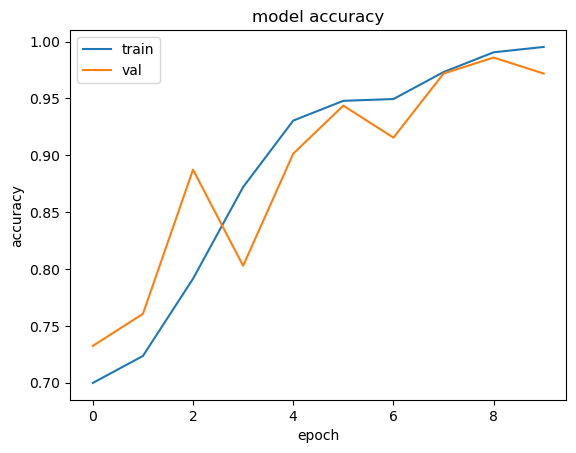

In [16]:
from matplotlib import pyplot as plt
plt.plot(hs.history['accuracy'])
plt.plot(hs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [134]:
def predict_output(x,model):
    tsr=[[0]*maxm for i in range(len(atoms))]
    k=0
    for j in x:
        tsr[atoms[j]][k]=1
        k+=1
    tsr=np.array(tsr).reshape(len(atoms),maxm,1)
    res=model.predict(np.array([tsr,]))
    if(res[0][0]>0.6):
        print("the drugs will interact with bortezomib " + str(res[0][0]))
    else:
        print("the drugs will not interact with bortezomib")

In [105]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

def draw_3d(mols):
    
    mol = Chem.MolFromSmiles(mols)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())


    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(mblock, 'sdf')
    viewer.setStyle({'stick':{}})
    viewer.setBackgroundColor('0xeeeeee')
    viewer.zoomTo()
    viewer.show()

def draw_2d(mols):
     return Draw.MolToImage(Chem.MolFromSmiles(mols),size=(400,400))


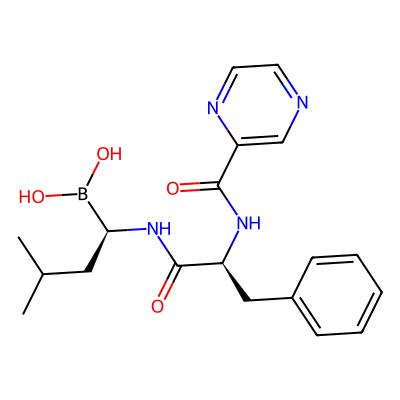

In [108]:

borte='CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=CN=CC=N1)B(O)O'
draw_2d(borte)

In [127]:
draw_3d(borte)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [153]:
comp="CC1=CC(=CC(C)=C1OC1=C(Br)C(N)=NC(NC2=CC=C(C=C2)C#N)=N1)C#N"


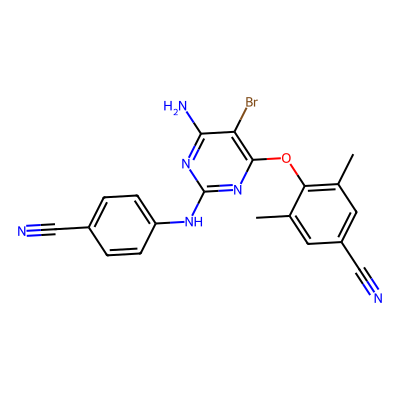

In [154]:
draw_2d(comp)

In [156]:
draw_3d(comp)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [157]:
from tensorflow import keras
model = keras.models.load_model('D:\\Phase II Project Work\\DRUG\\Drug_CNN\\DDI.h5')

In [158]:
predict_output(comp,model)

1/1 [==============================] - 0s 81ms/step
the drugs will interact with bortezomib 0.9997389
